In [1]:
# Install dependencies
!pip install kagglehub nltk scikit-learn tensorflow pandas numpy matplotlib

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached regex-2025.11.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## Dataset Acquisition

Loading sarcasm headlines dataset from Kaggle.

In [3]:
import kagglehub
import os

# Download dataset
dataset_path = kagglehub.dataset_download("shariphthapa/sarcasm-json-datasets")
print(f"Dataset downloaded to: {dataset_path}")

# Locate the JSON file
json_candidates = [
    os.path.join(dataset_path, "Sarcasm.json"),
    os.path.join(dataset_path, "Sarcasm_Headlines_Dataset.json")
]

json_file = next((f for f in json_candidates if os.path.exists(f)), None)

if not json_file:
    raise FileNotFoundError("Dataset JSON file not found")

print(f"Loading: {json_file}")

100%|██████████| 1.59M/1.59M [00:00<00:00, 1.74MB/s]

Extracting files...
Dataset downloaded to: /home/jalaleddin/.cache/kagglehub/datasets/shariphthapa/sarcasm-json-datasets/versions/1
Loading: /home/jalaleddin/.cache/kagglehub/datasets/shariphthapa/sarcasm-json-datasets/versions/1/Sarcasm.json
Dataset downloaded to: /home/jalaleddin/.cache/kagglehub/datasets/shariphthapa/sarcasm-json-datasets/versions/1
Loading: /home/jalaleddin/.cache/kagglehub/datasets/shariphthapa/sarcasm-json-datasets/versions/1/Sarcasm.json


In [4]:
# Load and explore dataset
try:
    data = pd.read_json(json_file, lines=True)
except ValueError:
    data = pd.read_json(json_file)

print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {data.columns.tolist()}")
print(f"\nFirst 3 rows:")
data.head(3)

Dataset shape: (26709, 3)

Columns: ['article_link', 'headline', 'is_sarcastic']

First 3 rows:


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1


In [5]:
# Remove unnecessary columns and check class distribution
data = data[['headline', 'is_sarcastic']].copy()

print("Class distribution:")
print(data['is_sarcastic'].value_counts())
print(f"\nSarcastic ratio: {data['is_sarcastic'].mean():.2%}")

# Show sample headlines
print("\nSample headlines:")
for label in [0, 1]:
    sample = data[data['is_sarcastic'] == label].iloc[0]['headline']
    label_name = "Sarcastic" if label == 1 else "Literal"
    print(f"  [{label_name}] {sample}")

Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

Sarcastic ratio: 43.90%

Sample headlines:
  [Literal] former versace store clerk sues over secret 'black code' for minority shoppers
  [Sarcastic] mom starting to fear son's web series closest thing she will have to grandchild


## Text Preprocessing

Cleaning and tokenizing headlines while removing stop words.

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

# Download NLTK data
for resource in ['punkt', 'punkt_tab', 'stopwords']:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource != 'stopwords' else 'corpora/stopwords')
    except LookupError:
        nltk.download(resource, quiet=True)

stop_words = set(stopwords.words('english'))
print(f"Loaded {len(stop_words)} English stop words")

Loaded 198 English stop words


In [7]:
def clean_text(text):
    """Normalize text: lowercase, remove punctuation, filter stop words"""
    if not isinstance(text, str):
        return []
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words and empty tokens
    tokens = [t for t in tokens if t and t not in stop_words]
    
    return tokens

# Apply preprocessing
data['tokens'] = data['headline'].apply(clean_text)

# Show preprocessing effect
print("Preprocessing examples:\n")
for idx in range(2):
    print(f"Original: {data['headline'].iloc[idx]}")
    print(f"Cleaned:  {' '.join(data['tokens'].iloc[idx])}\n")

Preprocessing examples:

Original: former versace store clerk sues over secret 'black code' for minority shoppers
Cleaned:  former versace store clerk sues secret black code minority shoppers

Original: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned:  roseanne revival catches thorny political mood better worse



## Vectorization with Tokenizer

Converting text to numerical sequences using vocabulary mapping.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Configure tokenizer
VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")

# Fit on cleaned text
text_corpus = [' '.join(tokens) for tokens in data['tokens']]
tokenizer.fit_on_texts(text_corpus)

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Using top {VOCAB_SIZE} words")
print(f"\nMost frequent words: {list(tokenizer.word_index.items())[:15]}")

2025-12-10 22:13:12.037103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 22:13:12.037353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 22:13:12.068276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 22:13:13.015486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Vocabulary size: 25220
Using top 5000 words

Most frequent words: [('<UNK>', 1), ('trump', 2), ('new', 3), ('man', 4), ('year', 5), ('one', 6), ('report', 7), ('area', 8), ('woman', 9), ('donald', 10), ('day', 11), ('u', 12), ('says', 13), ('time', 14), ('first', 15)]


In [9]:
# Convert to sequences and pad
sequences = tokenizer.texts_to_sequences(text_corpus)

# Determine sequence length
seq_lengths = [len(s) for s in sequences]
MAX_LENGTH = min(max(seq_lengths), 100)

print(f"Sequence length statistics:")
print(f"  Mean: {np.mean(seq_lengths):.1f}")
print(f"  Max: {max(seq_lengths)}")
print(f"  Using: {MAX_LENGTH}")

# Pad sequences
X_padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

print(f"\nPadded sequences shape: {X_padded.shape}")

Sequence length statistics:
  Mean: 7.2
  Max: 27
  Using: 27

Padded sequences shape: (26709, 27)


## Baseline Model: Logistic Regression

Training on token indices as features.

In [10]:
# Prepare data
X = X_padded.astype('float32')
y = data['is_sarcastic'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 20031
Testing samples: 6678


In [11]:
# Train baseline model
baseline_model = LogisticRegression(
    max_iter=3000, 
    random_state=42, 
    class_weight='balanced',
    solver='lbfgs'
)

print("Training baseline model...")
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Metrics
acc_baseline = accuracy_score(y_test, y_pred_baseline)
auc_baseline = roc_auc_score(y_test, y_proba_baseline)

print(f"\nBaseline Results:")
print(f"  Accuracy: {acc_baseline:.4f}")
print(f"  ROC AUC: {auc_baseline:.4f}")

Training baseline model...

Baseline Results:
  Accuracy: 0.5690
  ROC AUC: 0.5636

Baseline Results:
  Accuracy: 0.5690
  ROC AUC: 0.5636


In [12]:
# Detailed baseline evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Not Sarcastic', 'Sarcastic']))

Confusion Matrix:
[[2597 1150]
 [1728 1203]]

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.60      0.69      0.64      3747
    Sarcastic       0.51      0.41      0.46      2931

     accuracy                           0.57      6678
    macro avg       0.56      0.55      0.55      6678
 weighted avg       0.56      0.57      0.56      6678



## Enhanced Model: Embedding Layer

Using learned word embeddings to capture semantic relationships.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# Embedding configuration
EMBEDDING_DIM = 64
VOCAB_INPUT_SIZE = VOCAB_SIZE + 1  # Account for padding

# Create embedding layer
embedding_layer = Sequential([
    Embedding(
        input_dim=VOCAB_INPUT_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LENGTH
    )
])

print(f"Embedding configuration:")
print(f"  Vocabulary: {VOCAB_INPUT_SIZE}")
print(f"  Dimensions: {EMBEDDING_DIM}")
print(f"  Sequence length: {MAX_LENGTH}")

Embedding configuration:
  Vocabulary: 5001
  Dimensions: 64
  Sequence length: 27


In [14]:
# Generate embeddings
print("Computing embeddings for all sequences...")
embeddings = embedding_layer.predict(X_padded, verbose=0)

print(f"Embedding tensor shape: {embeddings.shape}")

# Aggregate embeddings (average pooling)
X_embedded = embeddings.mean(axis=1)

print(f"Aggregated embeddings shape: {X_embedded.shape}")

Computing embeddings for all sequences...


E0000 00:00:1765401261.743034   74350 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765401261.753067   74350 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Embedding tensor shape: (26709, 27, 64)
Aggregated embeddings shape: (26709, 64)


In [15]:
# Split embedded data
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_embedded, y, test_size=0.25, random_state=42, stratify=y
)

# Train on embeddings
embedding_model = LogisticRegression(
    max_iter=3000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)

print("Training embedding-based model...")
embedding_model.fit(X_train_emb, y_train_emb)

# Predictions
y_pred_emb = embedding_model.predict(X_test_emb)
y_proba_emb = embedding_model.predict_proba(X_test_emb)[:, 1]

# Metrics
acc_emb = accuracy_score(y_test_emb, y_pred_emb)
auc_emb = roc_auc_score(y_test_emb, y_proba_emb)

print(f"\nEmbedding Model Results:")
print(f"  Accuracy: {acc_emb:.4f}")
print(f"  ROC AUC: {auc_emb:.4f}")

Training embedding-based model...

Embedding Model Results:
  Accuracy: 0.5496
  ROC AUC: 0.5895


In [16]:
# Detailed embedding model evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test_emb, y_pred_emb))

print("\nClassification Report:")
print(classification_report(y_test_emb, y_pred_emb, 
                          target_names=['Not Sarcastic', 'Sarcastic']))

Confusion Matrix:
[[2094 1653]
 [1355 1576]]

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.61      0.56      0.58      3747
    Sarcastic       0.49      0.54      0.51      2931

     accuracy                           0.55      6678
    macro avg       0.55      0.55      0.55      6678
 weighted avg       0.55      0.55      0.55      6678



## Model Comparison

Analyzing performance differences between approaches.

In [17]:
# Performance comparison
comparison = pd.DataFrame({
    'Model': ['Baseline (Token IDs)', 'Embedding-based'],
    'Accuracy': [acc_baseline, acc_emb],
    'ROC AUC': [auc_baseline, auc_emb]
})

print(comparison.to_string(index=False))

# Calculate improvements
acc_diff = (acc_emb - acc_baseline) * 100
auc_diff = auc_emb - auc_baseline

print(f"\nImprovement with embeddings:")
print(f"  Accuracy: {acc_diff:+.2f} percentage points")
print(f"  ROC AUC: {auc_diff:+.4f}")

               Model  Accuracy  ROC AUC
Baseline (Token IDs)  0.569033 0.563616
     Embedding-based  0.549566 0.589506

Improvement with embeddings:
  Accuracy: -1.95 percentage points
  ROC AUC: +0.0259


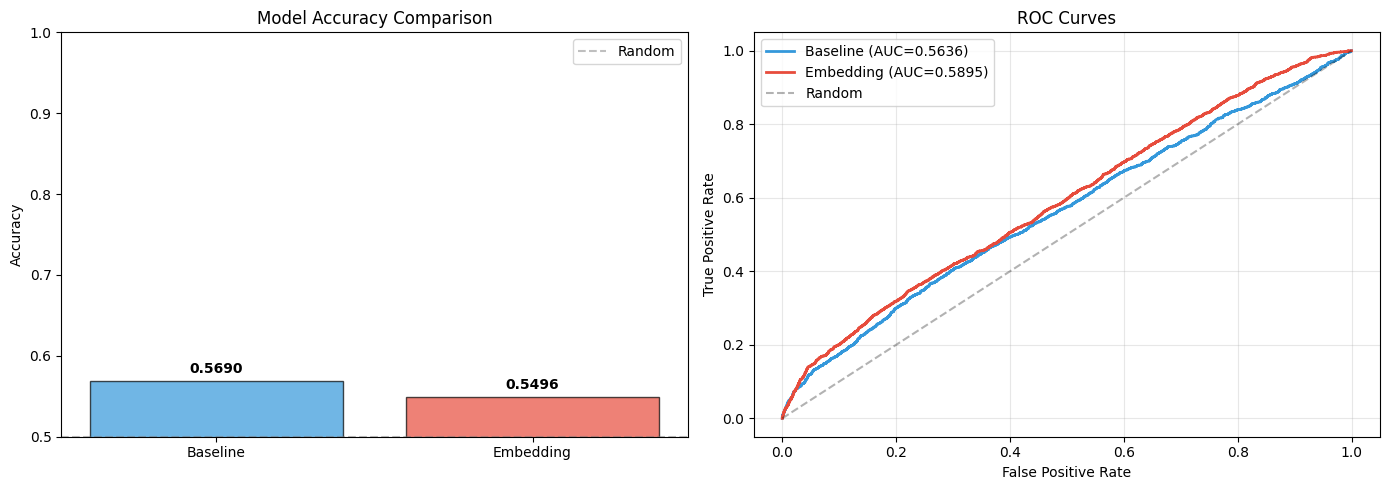

In [18]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['Baseline', 'Embedding']
accuracies = [acc_baseline, acc_emb]
colors = ['#3498db', '#e74c3c']

axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim(0.5, 1.0)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
axes[0].legend()

for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# ROC curves
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
fpr_emb, tpr_emb, _ = roc_curve(y_test_emb, y_proba_emb)

axes[1].plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC={auc_baseline:.4f})', 
            color=colors[0], linewidth=2)
axes[1].plot(fpr_emb, tpr_emb, label=f'Embedding (AUC={auc_emb:.4f})', 
            color=colors[1], linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Test on custom headlines
def predict_sarcasm(headline, use_embedding=True):
    """Predict if a headline is sarcastic"""
    # Preprocess
    tokens = clean_text(headline)
    text = ' '.join(tokens)
    
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LENGTH, padding='post')
    
    if use_embedding:
        # Use embedding model
        emb = embedding_layer.predict(padded, verbose=0).mean(axis=1)
        prob = embedding_model.predict_proba(emb)[0, 1]
        pred = embedding_model.predict(emb)[0]
    else:
        # Use baseline model
        prob = baseline_model.predict_proba(padded)[0, 1]
        pred = baseline_model.predict(padded)[0]
    
    return pred, prob

# Test examples
test_headlines = [
    "Local Man Wins Nobel Prize for Physics",
    "Area Man Knows All The Shortcuts That Will Save You Time",
    "Scientists Discover Cure for Major Disease",
    "Nation's Girlfriends Unveil New Economic Plan: Let's Just Stay In Tonight"
]

print("Testing custom headlines:\n")
for headline in test_headlines:
    pred, prob = predict_sarcasm(headline, use_embedding=True)
    label = "SARCASTIC" if pred == 1 else "LITERAL"
    print(f"{label} ({prob:.2%}): {headline}")

Testing custom headlines:

LITERAL (46.85%): Local Man Wins Nobel Prize for Physics
LITERAL (46.81%): Area Man Knows All The Shortcuts That Will Save You Time
LITERAL (43.33%): Scientists Discover Cure for Major Disease
SARCASTIC (53.99%): Nation's Girlfriends Unveil New Economic Plan: Let's Just Stay In Tonight
